**Customer Support Email Sentiment Analysis**

Using tweeter customer support data for sentiment analysis.

After preprocessing of Data will keep only inbound tweet text , As the project aim is to do Sentiment analysis on customer support email body

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk import word_tokenize,sent_tokenize
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re

from nltk.sentiment.vader import SentimentIntensityAnalyzer


import smtplib
import email
import imaplib

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt')



/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
os.chdir("/content/drive/MyDrive/UST-Hackathon")

In [3]:
cs_data = pd.read_csv('twcs.csv')
cs_data.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [4]:
cs_data.shape

(2811774, 7)

In [5]:
cs_data.inbound.value_counts()

True     1537843
False    1273931
Name: inbound, dtype: int64

In [6]:
#Working only inbound entries i.e tweets made by customers only without replies

In [7]:
inbound_cs_data=cs_data[cs_data['inbound']==True]

In [8]:
inbound_cs_data.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0


In [9]:
inbound_cs_data.isna().sum() # Checking for NaN values


tweet_id                        0
author_id                       0
inbound                         0
created_at                      0
text                            0
response_tweet_id          234014
in_response_to_tweet_id    787346
dtype: int64

Since we are working on only inbound CS tweets so we can drop response_tweet_id and in_response_to_tweet_id

In [10]:
inbound_cs_data.drop(['response_tweet_id','in_response_to_tweet_id'], axis = 1,inplace=True)

In [11]:
inbound_cs_data.drop(['tweet_id','inbound','created_at'], axis = 1,inplace=True)

In [12]:
inbound_cs_data.head()

,author_id,text
1,115712,@sprintcare and how do you propose we do that
2,115712,@sprintcare I have sent several private messag...
4,115712,@sprintcare I did.
6,115712,@sprintcare is the worst customer service
8,115713,@sprintcare You gonna magically change your co...


**Preprocess data**
* convert all text to lowercase -
* select only numbers, alphabets, and #+_ from text - 
* this is for removing extra spaces
* remove html tags
* remove punctuation like . ,

In [13]:
stopword = stopwords.words('english')

def removeStopWords(text):
  text_tokens = word_tokenize(text)
  tokens_without_sw = [word for word in text_tokens if not word in stopword]
  filtered_sentence = (" ").join(tokens_without_sw)
  return filtered_sentence

In [14]:
#Creating a function to replace all symbols using regex. Also using using strip function to remove extra spaces

def preprocess(text, remove_digits=False):
  #to lower case
    text=text.lower()
    #remove digits
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    #remove html tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    text = cleantext.replace('[^\w\s]','')
    text_1 = removeStopWords(text)
    return text_1

In [15]:
inbound_cs_data['text'] = [preprocess(text) for text in inbound_cs_data.text]

In [16]:
inbound_cs_data['text'].head()

1                                   sprintcare propose
2    sprintcare sent several private messages one r...
4                                           sprintcare
6                    sprintcare worst customer service
8    sprintcare gon na magically change connectivit...
Name: text, dtype: object

In [17]:
inbound_cs_data['text_len']  = inbound_cs_data['text'].str.len()

In [18]:
inbound_cs_data.head()

,author_id,text,text_len
1,115712,sprintcare propose,18
2,115712,sprintcare sent several private messages one r...,61
4,115712,sprintcare,10
6,115712,sprintcare worst customer service,33
8,115713,sprintcare gon na magically change connectivit...,60


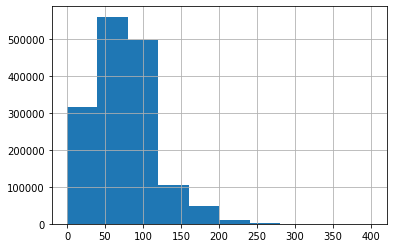

In [19]:
#Distribution of Length
inbound_cs_data.text.str.len().hist()

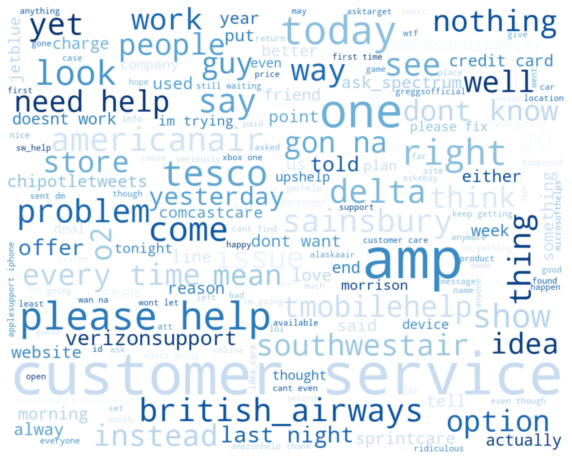

In [20]:
#Bag of words (Most common words)
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'Blues', 
                       margin = 0,
                       max_words = 200,  
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(inbound_cs_data['text']))

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()

**Sendiment analysis**

In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [22]:
# Instantiate sentiment analyzer from NLTK, make "sentiment_analyze" function
sentiment_analyzer = SentimentIntensityAnalyzer()

def sentiment_analyze(text: str) -> float:
    return sentiment_analyzer.polarity_scores(text)['compound']

In [ ]:
# Analyze customer sentiment based on their messages
inbound_cs_data['sentiment'] = inbound_cs_data.text.apply(sentiment_analyze)

In [ ]:
inbound_cs_data.head()

In [ ]:
print("Negative sediments ",inbound_cs_data[inbound_cs_data['sentiment']<0].count())

In [ ]:
print("Positive sediments ",inbound_cs_data[inbound_cs_data['sentiment']>0].count())

In [ ]:
hist_bins = 30
plt.figure(figsize=[10,5])
x = inbound_cs_data[['sentiment']]
scores_hist,edges = np.histogram(x, bins=hist_bins)
plt.bar(edges[:-1], scores_hist)
plt.grid(True)
plt.xlabel('Score')
plt.ylabel('Tweets Count')
plt.show()

**We Need to Send email for Cases where negative score is High i.e customer is very unhappy**

In [ ]:
alert_threshold = -0.7
inbound_cs_data[inbound_cs_data.sentiment <= alert_threshold]

**Methods to read unread mail and send mail to customer support**

In [ ]:
def readMail():
  mail = imaplib.IMAP4_SSL('imap.googlemail.com')
  (retcode, capabilities) = mail.login('test@gmail.com','test')
  mail.list()
  mail.select('inbox')

  n=0
  (retcode, messages) = mail.search(None, '(UNSEEN)')
  if retcode == 'OK':

    for num in messages[0].split() :
        print ('Processing ')
        n=n+1
        typ, data = mail.fetch(num,'(RFC822)')
        for response_part in data:
          if isinstance(response_part, tuple):
              original = email.message_from_bytes(response_part[1])
              raw_email = data[0][1]
              raw_email_string = raw_email.decode('utf-8')
              email_message = email.message_from_string(raw_email_string)
              for part in email_message.walk():
                          if (part.get_content_type() == "text/plain"): # ignore attachments/html
                                body = part.get_payload(decode=True)
                                fromSender = original['From']
                                text=body.decode('utf-8')
                                list.append(fromSender)
                                list.append(text)
                          else:
                                continue

              typ, data = mail.store(num,'+FLAGS','\\Seen')
    return list

In [ ]:
def sendMail(fromemail):
  print("mail sent to custmoer care for unhappy customer")
  sender = 'test@mail.com'
  receivers = ['customcare@gmail.com']
  message = "Please solve query of unhappy customer with email id"+fromemail
  try:
    smtpObj = smtplib.SMTP('localhost')
    smtpObj.sendmail(sender, receivers, message)         
    print ("Successfully sent email")
  except Exception:
    print ("email send error")

Test preprocess and sentiment analysis flow

In [ ]:
msg_body="Very disappointed. Very bad service. Worst product"

In [ ]:
msg=preprocess(msg_body)

In [ ]:
score=sentiment_analyze(msg)
print(score)

In [ ]:
msg_body="working as expected"

In [ ]:
msg=preprocess(msg_body)
score=sentiment_analyze(msg)
print(score)

In [ ]:
msg_body="working good"
msg=preprocess(msg_body)
score=sentiment_analyze(msg)
print(score)

**Email Sendiment analysis Flow**
* Read mail and check if there is unread message
* Apply preprocessing to unread message body
* Calculate score
* If negative score id high send mail to customer care staff to look into it

In [ ]:
alert_threshold = -0.7
senderAndBody = readMail()
#msg_body = senderAndBody[1]
#fromSender = senderAndBody[1]
fromSender="test@gmail.com"
msg_body="Very disappointed. Very bad service. Worst product"
if msg_body!= "":
  msg=preprocess(msg_body)
  score=sentiment_analyze(msg)
  print("score ",score)
  if score < alert_threshold:
    print("threashold breached")
    sendMail(fromSender)

score  -0.8934
threashold breached
mail sent to custmoer care for unhappy customer
email send
